# MNIST handwritten digit classification with MLPs

In this notebook, we'll train a multi-layer perceptron model to classify MNIST digits using **PyTorch**. 

First, the needed imports. 

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import numpy as np
import matplotlib.pyplot as plt
import os

print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.') 
    device = torch.device('cpu')

Using PyTorch version: 2.9.0+cpu
No GPU found, using CPU instead.


## Loading data

PyTorch has two classes from [`torch.utils.data` to work with data](https://pytorch.org/docs/stable/data.html#module-torch.utils.data): 
- [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) which represents the actual data items, such as images or pieces of text, and their labels
- [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) which is used for processing the dataset in batches in an efficient manner.

Here we will use TorchVision and `torchvision.datasets` which provides easy access to [many common visual datasets](https://pytorch.org/vision/stable/datasets.html). In this example we'll use the [MNIST class](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) for loading the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database).

In [2]:
batch_size = 32

slurm_project = os.getenv('SLURM_JOB_ACCOUNT')
data_dir = os.path.join('/scratch', slurm_project, 'data') if slurm_project else './data'
print('data_dir =', data_dir)

train_dataset = datasets.MNIST(data_dir, train=True, download=True, transform=ToTensor())
test_dataset = datasets.MNIST(data_dir, train=False, transform=ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

data_dir = ./data


100%|██████████| 9.91M/9.91M [00:01<00:00, 6.93MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 222kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.38MB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


The data loaders provide a way of iterating (making a loop over) the datasets, each time getting a new batch of data with the given batch size.

The first element of the data batch (`data`) is a 4th-order tensor of size (`batch_size`, 1, 28, 28), i.e. it consists of a batch of images of size 1x28x28 pixels, where the first value is the number of color channels (only 1 in this case as it's gray scale).

The second element of the batch (`target`) is a vector containing the correct (or "target") classes ("0", "1", ..., "9") for each training digit.

In [3]:
for (data, target) in train_loader:
    print('data:', data.size(), 'type:', data.type())
    print('target:', target.size(), 'type:', target.type())
    break

data: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
target: torch.Size([32]) type: torch.LongTensor


Here are the first 10 training digits:

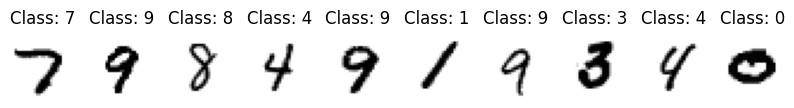

In [4]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(data[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(target[i].item()))

## Multi-layer perceptron (MLP) network

In PyTorch, a neural network is defined as a Python class. It needs to have two methods:

- `__init__()` which initializes the layers used in the network
- `forward()` which defines how the network performs a forward pass

PyTorch will then automatically generate a `backward()` method that computes the gradients based on the computation done in the forward pass.

All the [neural network building blocks defined in PyTorch can be found in the torch.nn documentation](https://pytorch.org/docs/stable/nn.html).

We use `nn.Sequential` to more easily create a simple sequental neural network:

- First we need to "flatten" the 2D image into a vector with `nn.Flatten`

- Next a fully-connected layer with 20 neurons is created with `nn.Linear`. Note that we need to specify the number of input and output connections. In this case there are 28x28=784 inputs, and 20 outputs

- Next, a ReLU non-linear activation

- Finally the output of the last layer needs to be a 10-dimensional vector to match the ground truth of ten classes (the ten digits).

The output of the last layer should be normalized with softmax, but this is actually included implicitly in the loss function in PyTorch (see below).

In [5]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 20),
            nn.ReLU(),
            nn.Linear(20, 10)
        )

    def forward(self, x):
        return self.layers(x)

model = SimpleMLP().to(device)
print(model)

SimpleMLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=20, bias=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=10, bias=True)
  )
)


# Training the model

In order to train the model we need to define a loss function and an optimizer.

For a classification task we typically use the cross entropy loss. For this we can use the class [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

**Note:** if you read the documentation of `CrossEntropyLoss` carefully you will see that it expects the unnormalized raw outputs of the model as softmax is included implicitly in PyTorch's implementation of `CrossEntropyLoss`. This is why we don't need to explicitly use softmax in the network definition above.

Finally, we need to define an optimizer, which tells how to update the model parameters based on the computed gradients. There are [several different optimizer algorithms implemented in PyTorch](https://pytorch.org/docs/stable/optim.html#algorithms).

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In PyTorch we have to write the training loop ourselves.

The code below consists of two loops:

- The outer loop goes over a number of *epochs*. An epoch is a single pass through the whole training data.
- The inner loop goes over all the batches of the dataset. Here we have defined the batch size to be 32, so images are handled 32 at a time.

For each batch we:

- Copy the data to the GPU with the `.to(device)` method. If we don't have a GPU, these commands will not do anything.

- Do a forward pass, which is as simple as: `output = model(data)`

- Finally we calculate the loss - that is the error between the output of the network and the target we want to get - using the `criterion` function we defined earlier

- The last lines do the backward propagation with `loss.backward()`, the weights are updated with `optimizer.step()` and finally we need to zero the gradient counters with `optimizer.zero_grad()`.

First, a helper function to calculate the number of correctly classified digits.

In [7]:
def correct(output, target):
    predicted_digits = output.argmax(1)                            # pick digit with largest network output
    correct_ones = (predicted_digits == target).type(torch.float)  # 1.0 for correct, 0.0 for incorrect
    return correct_ones.sum().item()                               # count number of correct ones


Next a function for a single training epoch.

In [8]:
def train(data_loader, model, criterion, optimizer):
    model.train()

    num_batches = len(data_loader)
    num_items = len(data_loader.dataset)

    total_loss = 0
    total_correct = 0
    for data, target in data_loader:
        # Copy data and targets to GPU
        data = data.to(device)
        target = target.to(device)
        
        # Do a forward pass
        output = model(data)
        
        # Calculate the loss
        loss = criterion(output, target)
        total_loss += loss

        # Count number of correct digits
        total_correct += correct(output, target)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss = total_loss/num_batches
    accuracy = total_correct/num_items
    print(f"Average loss: {train_loss:7f}, accuracy: {accuracy:.2%}")


In [9]:
%%time

epochs = 10
for epoch in range(epochs):
    print(f"Training epoch: {epoch+1}")
    train(train_loader, model, criterion, optimizer)

Training epoch: 1
Average loss: 0.434671, accuracy: 88.36%
Training epoch: 2
Average loss: 0.253356, accuracy: 92.76%
Training epoch: 3
Average loss: 0.211511, accuracy: 93.95%
Training epoch: 4
Average loss: 0.183638, accuracy: 94.73%
Training epoch: 5
Average loss: 0.164996, accuracy: 95.16%
Training epoch: 6
Average loss: 0.150278, accuracy: 95.58%
Training epoch: 7
Average loss: 0.140057, accuracy: 95.85%
Training epoch: 8
Average loss: 0.132683, accuracy: 96.08%
Training epoch: 9
Average loss: 0.125136, accuracy: 96.29%
Training epoch: 10
Average loss: 0.120192, accuracy: 96.43%
CPU times: total: 1min 2s
Wall time: 54.9 s


### Inference

For a better measure of the quality of the model, let's see the model accuracy for the test data.

The code is similar to the training code: we just loop over the whole testset, but no need to do backpropagation or calculate any gradients this time.

In [10]:
def test(test_loader, model, criterion):
    model.eval()

    num_batches = len(test_loader)
    num_items = len(test_loader.dataset)

    test_loss = 0
    total_correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            # Copy data and targets to GPU
            data = data.to(device)
            target = target.to(device)
        
            # Do a forward pass
            output = model(data)
        
            # Calculate the loss
            loss = criterion(output, target)
            test_loss += loss.item()
        
            # Count number of correct digits
            total_correct += correct(output, target)

    test_loss = test_loss/num_batches
    accuracy = total_correct/num_items

    print(f"Testset accuracy: {100*accuracy:>0.1f}%, average loss: {test_loss:>7f}")

In [11]:
test(test_loader, model, criterion)

Testset accuracy: 95.8%, average loss: 0.142813


## Task 1: Model with two linear layers

Your task is to try the same problem as above, but with a more complex model. The new model should have **two linear layers**, each with:

- 50 units
- ReLU activation
- each followed by a dropout layer with a rate of 0.2 - hint: try [nn.Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout)

Dropout randomly sets a fraction of inputs to zero during training, which is one approach to regularization and can sometimes help to prevent overfitting.

You can consult the [PyTorch documentation](https://pytorch.org/docs/stable/index.html), in particular all the [neural network building blocks can be found in the `torch.nn` documentation](https://pytorch.org/docs/stable/nn.html).

The code below is missing the model definition. You can copy any suitable layers from the example above.

In [12]:
class TwoLayerMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        return self.layers(x)


If you want to see an example answer, change the type of the cell below to "Code" in the menu bar above and then execute the cell. Execute the cell again to run the example code.

**Note:** in Google Colab you can [click here](https://github.com/csc-training/intro-to-dl/blob/master/day1/solutions/pytorch-mnist-mlp-example-answer.py) and copy the answer manually.

In [13]:
ex1_model = TwoLayerMLP()
print(ex1_model)

assert len(ex1_model.layers) > 0, "ERROR: You need to write the missing model definition above!"
ex1_model = ex1_model.to(device)

TwoLayerMLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=50, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=50, out_features=10, bias=True)
  )
)


In [14]:
ex1_criterion = nn.CrossEntropyLoss()
ex1_optimizer = torch.optim.Adam(ex1_model.parameters())

In [15]:
%%time

epochs = 10
for epoch in range(epochs):
    print(f"Epoch: {epoch+1} ...")
    train(train_loader, ex1_model, ex1_criterion, ex1_optimizer)

Epoch: 1 ...
Average loss: 0.480095, accuracy: 85.57%
Epoch: 2 ...
Average loss: 0.261078, accuracy: 92.19%
Epoch: 3 ...
Average loss: 0.215082, accuracy: 93.62%
Epoch: 4 ...
Average loss: 0.191965, accuracy: 94.19%
Epoch: 5 ...
Average loss: 0.174036, accuracy: 94.76%
Epoch: 6 ...
Average loss: 0.163004, accuracy: 95.09%
Epoch: 7 ...
Average loss: 0.151970, accuracy: 95.39%
Epoch: 8 ...
Average loss: 0.148283, accuracy: 95.50%
Epoch: 9 ...
Average loss: 0.138497, accuracy: 95.77%
Epoch: 10 ...
Average loss: 0.134498, accuracy: 95.85%
CPU times: total: 2min 23s
Wall time: 1min 54s


In [16]:
test(test_loader, ex1_model, ex1_criterion)

Testset accuracy: 97.0%, average loss: 0.100852


## Task 2: Model tuning

Modify the MLP model.  Try to improve the classification accuracy, or experiment with the effects of different parameters.  If you are interested in the state-of-the-art performance on permutation invariant MNIST, see e.g. [this paper](https://arxiv.org/abs/1507.02672) by Aalto University / The Curious AI Company researchers.

## Task 3: Fashion-MNIST

MNIST can be replaced with Fashion-MNIST, which can be used as drop-in replacement for MNIST. Fashion-MNIST contains images of 10 fashion categories:

Label|Description|Label|Description
--- | --- |--- | ---
0|T-shirt/top|5|Sandal
1|Trouser|6|Shirt
2|Pullover|7|Sneaker
3|Dress|8|Bag
4|Coat|9|Ankle boot

Replace the loading of MNIST data with Fashion-MNIST in the beginning of this notebook and re-run the experiments. [Fashion-MNIST can be found with the dataset class `FashionMNIST`](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST).

In [17]:
train_dataset = datasets.FashionMNIST(data_dir, train=True, download=True, transform=ToTensor())
test_dataset = datasets.FashionMNIST(data_dir, train=False, transform=ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 391kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 9.24MB/s]
100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]


In [18]:
for (data, target) in train_loader:
    print('data:', data.size(), 'type:', data.type())
    print('target:', target.size(), 'type:', target.type())
    break

data: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
target: torch.Size([32]) type: torch.LongTensor


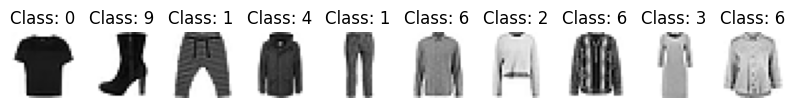

In [19]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(data[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(target[i].item()))

In [20]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 20),
            nn.ReLU(),
            nn.Linear(20, 10)
        )

    def forward(self, x):
        return self.layers(x)

model = SimpleMLP().to(device)
print(model)

SimpleMLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=20, bias=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=10, bias=True)
  )
)


In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [22]:
def correct(output, target):
    predicted_digits = output.argmax(1)                            # pick digit with largest network output
    correct_ones = (predicted_digits == target).type(torch.float)  # 1.0 for correct, 0.0 for incorrect
    return correct_ones.sum().item()                               # count number of correct ones


In [23]:
def train(data_loader, model, criterion, optimizer):
    model.train()

    num_batches = len(data_loader)
    num_items = len(data_loader.dataset)

    total_loss = 0
    total_correct = 0
    for data, target in data_loader:
        # Copy data and targets to GPU
        data = data.to(device)
        target = target.to(device)
        
        # Do a forward pass
        output = model(data)
        
        # Calculate the loss
        loss = criterion(output, target)
        total_loss += loss

        # Count number of correct digits
        total_correct += correct(output, target)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss = total_loss/num_batches
    accuracy = total_correct/num_items
    print(f"Average loss: {train_loss:7f}, accuracy: {accuracy:.2%}")


In [24]:
%%time

epochs = 10
for epoch in range(epochs):
    print(f"Training epoch: {epoch+1}")
    train(train_loader, model, criterion, optimizer)

Training epoch: 1
Average loss: 0.618303, accuracy: 79.02%
Training epoch: 2
Average loss: 0.448105, accuracy: 84.45%
Training epoch: 3
Average loss: 0.422888, accuracy: 85.33%
Training epoch: 4
Average loss: 0.404530, accuracy: 85.88%
Training epoch: 5
Average loss: 0.392762, accuracy: 86.24%
Training epoch: 6
Average loss: 0.383874, accuracy: 86.50%
Training epoch: 7
Average loss: 0.374332, accuracy: 86.74%
Training epoch: 8
Average loss: 0.364556, accuracy: 87.05%
Training epoch: 9
Average loss: 0.359464, accuracy: 87.29%
Training epoch: 10
Average loss: 0.351428, accuracy: 87.50%
CPU times: total: 1min 24s
Wall time: 1min 13s


In [25]:
def test(test_loader, model, criterion):
    model.eval()

    num_batches = len(test_loader)
    num_items = len(test_loader.dataset)

    test_loss = 0
    total_correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            # Copy data and targets to GPU
            data = data.to(device)
            target = target.to(device)
        
            # Do a forward pass
            output = model(data)
        
            # Calculate the loss
            loss = criterion(output, target)
            test_loss += loss.item()
        
            # Count number of correct digits
            total_correct += correct(output, target)

    test_loss = test_loss/num_batches
    accuracy = total_correct/num_items

    print(f"Testset accuracy: {100*accuracy:>0.1f}%, average loss: {test_loss:>7f}")

In [26]:
test(test_loader, ex1_model, ex1_criterion)

Testset accuracy: 5.0%, average loss: 12.276412


In [46]:
class TwoLayerMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        return self.layers(x)


In [47]:
ex1_model = TwoLayerMLP()
print(ex1_model)

assert len(ex1_model.layers) > 0, "ERROR: You need to write the missing model definition above!"
ex1_model = ex1_model.to(device)

TwoLayerMLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=100, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.1, inplace=False)
    (7): Linear(in_features=50, out_features=10, bias=True)
  )
)


In [48]:
ex1_criterion = nn.CrossEntropyLoss()
ex1_optimizer = torch.optim.Adam(ex1_model.parameters())

In [49]:
%%time

epochs = 10
for epoch in range(epochs):
    print(f"Epoch: {epoch+1} ...")
    train(train_loader, ex1_model, ex1_criterion, ex1_optimizer)

Epoch: 1 ...
Average loss: 0.571529, accuracy: 79.30%
Epoch: 2 ...
Average loss: 0.407395, accuracy: 85.20%
Epoch: 3 ...
Average loss: 0.369533, accuracy: 86.61%
Epoch: 4 ...
Average loss: 0.348046, accuracy: 87.23%
Epoch: 5 ...
Average loss: 0.330470, accuracy: 87.88%
Epoch: 6 ...
Average loss: 0.321406, accuracy: 88.26%
Epoch: 7 ...
Average loss: 0.308293, accuracy: 88.66%
Epoch: 8 ...
Average loss: 0.299187, accuracy: 88.83%
Epoch: 9 ...
Average loss: 0.295509, accuracy: 89.14%
Epoch: 10 ...
Average loss: 0.287446, accuracy: 89.31%
CPU times: total: 3min 5s
Wall time: 2min 24s


In [50]:
test(test_loader, ex1_model, ex1_criterion)

Testset accuracy: 88.4%, average loss: 0.337540
